In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

from src.utils.utils_fn import *
from config.config import settings
import pandas as pd
import joblib
import json
import toml

import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# Lectura del dataset
data_path = settings.DATA_DIR / 'processed/data_processed.parquet'
data = pd.read_parquet(path=str(data_path))

# Setear los ids como índices
data: pd.DataFrame = data.set_index('product_id')
data.sample(5, random_state=10)

,condition,state,city,local_pickup,free_shipping,shipping_mode,listing_type,buying_mode,attribute_group_id,attribute_group,...,status,accepts_mercadopago,currency,automatic_relist,title,stock_quantity,available_quantity,total_amount,date_difference_hr,time_difference_hr
product_id,,,,,,,,,,,,,,,,,,,,,
mla5501620002,used,capital federal,nuñez,True,False,not_specified,bronze,buy_it_now,None,None,...,active,True,ars,False,timbre inahalambrico,1,1,0.0,0.000833,1440.0
mla2357269269,used,buenos aires,avellaneda,True,False,not_specified,bronze,buy_it_now,dflt,otros,...,active,True,ars,False,lote de 2 cinturones. 1 nuevo con etiqueta.mic...,8,8,0.0,695.485278,1440.0
mla4505955642,used,buenos aires,acassuso,True,False,me2,bronze,buy_it_now,None,None,...,active,True,ars,False,revista instituto de historia del derecho rica...,3,3,0.0,0.000833,1440.0
mla7853937105,used,capital federal,retiro,True,False,not_specified,free,buy_it_now,None,None,...,active,True,ars,False,susan sontag - la enfermedad y sus metaforas -...,1,1,0.0,0.000833,1440.0
mla7813601724,new,capital federal,almagro,True,False,not_specified,silver,buy_it_now,None,None,...,active,True,ars,False,vendas cambric marca vendsur de 10cm x 3mt en ...,7,7,2010.0,0.000556,1440.0


In [3]:
# Separación de los conjuntos de datos
# ===================================================================================================================
from sklearn.model_selection import train_test_split

# Inicializar una semilla
SEED = 25

# Separamos los features y el target
X = data.loc[:, data.columns != 'condition'] # type: ignore
y = data.loc[:, data.columns == 'condition'].squeeze() # type: ignore

# Verificar que los índices coinciden
assert (X.index == y.index).all(), 'Los índices de X e y no coinciden'

# Dividir el conjunto original en 70% entrenamiento y 30% para pruebas y validación
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=0.4, 
    random_state=SEED, 
    stratify=y
)

# Luego, dividir el 30% restante en 20% para validación y 10% para pruebas
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=1/2, 
    random_state=SEED, 
    stratify=y_temp
)

# Categóricas
X_train['local_pickup'] = X_train['local_pickup'].astype('category')
X_val['local_pickup'] = X_val['local_pickup'].astype('category')
X_test['local_pickup'] = X_test['local_pickup'].astype('category')

In [4]:
from sklearn.preprocessing import LabelEncoder

# Codificación del target
le = LabelEncoder()
y_train = pd.Series(le.fit_transform(y_train), index=y_train.index)
y_val = pd.Series(le.transform(y_val), index=y_val.index)
y_test = pd.Series(le.transform(y_test), index=y_test.index)

In [5]:
from sklearn.pipeline import Pipeline

# Pipeline de procesamiento
pipe_feature_selection = joblib.load(f'{settings.SRC_DIR}/pipelines/pipeline_feature_selection.pkl')
pipe_feature_engineering = joblib.load(f'{settings.SRC_DIR}/pipelines/pipeline_feature_engineering.pkl')
pipe = Pipeline([
    ('feature_selection', pipe_feature_selection),
    ('feature_engineering', pipe_feature_engineering)
])

print(pipe.get_params())

{'memory': None, 'steps': [('feature_selection', Pipeline(steps=[('drop-features',
                 DropFeatures(features_to_drop=['attribute_group_id',
                                                'attribute_group',
                                                'attribute_id', 'title',
                                                'city'])),
                ('constant-features',
                 DropConstantFeatures(missing_values='ignore', tol=0.95,
                                      variables=['stock_quantity',
                                                 'available_quantity',
                                                 'total_amount',
                                                 'date_difference_hr',
                                                 'time_difference_hr', 'state',
                                                 'local_pickup',
                                                 'free_ship...
                                                 'listi

In [6]:
# Ejecución
pipe.fit(X_train, y_train)
X_train = pipe.transform(X_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(X_test)

In [7]:
import xgboost as xgb

# Crear un objeto Booster vacío
model = xgb.Booster()

# Cargar el modelo desde un archivo JSON
model.load_model(f'{settings.MODELS_DIR}/artifacts/final_model.json')

In [ ]:
from xgboost import XGBClassifier

default_params = toml.load(f'{str(settings.CONFIG_DIR)}/config.toml')['xgb-default-params']
tunned_params = toml.load(f'{str(settings.CONFIG_DIR)}/config.toml')['xgb-tunned-params']

default_params.pop('eta', None)
hyper_params = tunned_params | default_params

early_stopping_rounds = 40
weight_dict = y_train_val.value_counts(normalize=True).to_dict()
sample_weight = np.array([weight_dict[val] for val in y_train_val])

model = XGBClassifier(**hyper_params, n_jobs=-1, early_stopping_rounds=early_stopping_rounds)

# Fitear
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

model.fit(
    X_train_val, 
    y_train_val,
    eval_set=[(X_val, y_val)],
    sample_weight=sample_weight,
    verbose=False
)

In [ ]:
from sklearn.metrics import roc_auc_score, log_loss

train_preds = model.predict_proba(X_train)[:, 1]
val_preds  = model.predict_proba(X_val)[:, 1]
test_preds  = model.predict_proba(X_test)[:, 1]

# Calcular las métricas
train_auc = roc_auc_score(y_train, train_preds)
train_logloss = log_loss(y_train, train_preds)

val_auc = roc_auc_score(y_val, val_preds)
val_logloss = log_loss(y_val, val_preds)

test_auc = roc_auc_score(y_test, test_preds)
test_logloss = log_loss(y_test, test_preds)

print(f'Train AUC: {train_auc:.4f}, Train Log-loss: {train_logloss:.4f}')
print(f'Val AUC: {val_auc:.4f}, Val Log-loss: {val_logloss:.4f}')
print(f'Test AUC: {test_auc:.4f}, Test Log-loss: {test_logloss:.4f}')

In [8]:
from sklearn.metrics import roc_auc_score, log_loss

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

train_preds = model.predict(dtrain)
val_preds  = model.predict(dval)
test_preds  = model.predict(dtest)

# Calcular las métricas
train_auc = roc_auc_score(y_train, train_preds)
train_logloss = log_loss(y_train, train_preds)

val_auc = roc_auc_score(y_val, val_preds)
val_logloss = log_loss(y_val, val_preds)

test_auc = roc_auc_score(y_test, test_preds)
test_logloss = log_loss(y_test, test_preds)

print(f'Train AUC: {train_auc:.4f}, Train Log-loss: {train_logloss:.4f}')
print(f'Val AUC: {val_auc:.4f}, Val Log-loss: {val_logloss:.4f}')
print(f'Test AUC: {test_auc:.4f}, Test Log-loss: {test_logloss:.4f}')

Train AUC: 0.8788, Train Log-loss: 0.4202
Val AUC: 0.8757, Val Log-loss: 0.4226
Test AUC: 0.8735, Test Log-loss: 0.4300


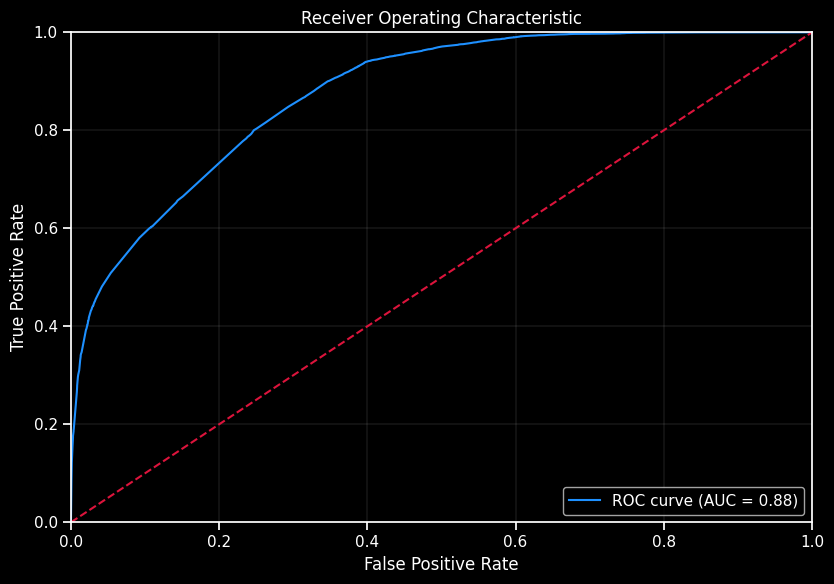

In [9]:
# Curva ROC con el modelo de línea base
roc_curve_plot(model, X_val, y_val)

In [ ]:
scores = model.get_score()
scores.values()
np.argsort(gains)[::-1]

array([0])

In [13]:
# Convertir el diccionario a listas para graficar
scores = model.get_score()
features = scores.keys()
gains = scores.values()

# Ordenar de mayor a menor
sorted_idx = np.argsort(gains)[::-1]
features_sorted = [features[i] for i in sorted_idx]
gains_sorted = [gains[i] for i in sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(features_sorted, gains_sorted, color='xkcd:dark orange', edgecolor='white', lw=0.5)
plt.xlabel('Ganancia promedio (gain)')
plt.title('Importancia de los predictores según su Ganancia promedio')
plt.gca().invert_yaxis()  # Para que la característica más importante esté en la parte superior
plt.tight_layout()

TypeError: 'dict_keys' object is not subscriptable

In [ ]:
# Convertir el diccionario a listas para graficar
features = model.feature_names_in_
gains = model.feature_importances_

# Ordenar de mayor a menor
sorted_idx = np.argsort(gains)[::-1]
features_sorted = [features[i] for i in sorted_idx]
gains_sorted = [gains[i] for i in sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(features_sorted, gains_sorted, color='xkcd:dark orange', edgecolor='white', lw=0.5)
plt.xlabel('Ganancia promedio (gain)')
plt.title('Importancia de los predictores según su Ganancia promedio')
plt.gca().invert_yaxis()  # Para que la característica más importante esté en la parte superior
plt.tight_layout()

AttributeError: 'Booster' object has no attribute 'feature_names_in_'

**Ganancia promedio (o mejora)** en la _función objetivo_ cuando la característica se utiliza para dividir. Esta métrica refleja cuánto contribuye en promedio cada división (en la que se utiliza esa feature) a la mejora del modelo, ya que no solo indica la frecuencia sino también el impacto en el rendimiento.

In [ ]:
# Predicciones del modelo
# Obtener las probabilidades de clase 1
probs = model.predict_proba(X_val)[:, 1]  # Probabilidad de que la muestra sea 1

# Calcular la probabilidad de clase 0
probs_0 = 1 - probs

# Obtener la predicción binaria con un umbral de 0.5
preds = (probs >= 0.5).astype(int)

# Crear el DataFrame con los resultados y reindexarlo con X_val.index
df = pd.DataFrame({
    'Probabilidad (Clase 0)': probs_0,
    'Probabilidad (Clase 1)': probs,
    'Predicción': preds
}, index=X_val.index)

# Mostrar una muestra aleatoria de 10 filas (para reproducibilidad se usa random_state)
df.sample(10, random_state=777)

In [ ]:
# Etiquetas reales
y_val.sample(10, random_state=777)

In [ ]:
# Reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(y_val, model.predict(X_val)))

In [11]:
from sklearn.metrics import brier_score_loss

# Predecir probabilidades de clase para datos de prueba
# y_pred = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(dval)

# Métricas
print(f'ROC-AUC de {type(model).__name__}: {100*roc_auc_score(y_val, y_pred):0.2f}%')
print(f'Brier Score de {type(model).__name__}: {100*brier_score_loss(y_val, y_pred):0.2f}%')

ROC-AUC de Booster: 87.57%
Brier Score de Booster: 14.12%


In [28]:
from netcal.regression import IsotonicRegression

# Suponiendo que 'model' es un Booster entrenado y 'dtest' es un DMatrix
probs = model.predict(dval)  # Probabilidades predichas (para un modelo binario, p(clase 1))

probs_2d = np.expand_dims(probs, axis=0)

# Instanciar el calibrador isotónico de netcal
calibrator = IsotonicRegression()  # Netcal proporciona este modelo de calibración

# Ajustar el calibrador con las probabilidades y las etiquetas verdaderas
# Nota: Es importante usar un conjunto de calibración independiente (por ejemplo, un conjunto de validación)
calibrator.fit(probs_2d, y_val)

# Obtener las probabilidades calibradas
calibrated_probs = calibrator.transform(probs_2d).flatten()

ValueError: `x` array is all-nan

In [23]:
calibrator

IsotonicRegression(fitted=True)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(
    model, 
    cv='prefit', 
    method='isotonic',
    n_jobs=-1
)
calibrated_model.fit(X_val, y_val)
calibrated_probs = calibrated_model.predict_proba(X_val)[:, 1]

In [ ]:
# Brier score del modelo calibrado
print(f'ROC-AUC de {type(calibrated_model).__name__}: {100*roc_auc_score(y_val, calibrated_probs):0.2f}%')
print(f'Brier Score de {type(calibrated_model).__name__}: {100*brier_score_loss(y_val, calibrated_probs):0.2f}%')